In [1]:
import warnings
warnings.filterwarnings('ignore')

# Bivariate Choropleth Maps

[Jeff Allen](http://jamaps.github.io)

April, 2023

Bivariate choropleth maps are pretty two-bular. They use colour to represent the values of two different data variables at the same time. Check out this map of neighbourhood material deprivation (a combined metric of lower income, education, employment rates, etc.) and quality of cycling infrastructure in Winnipeg.   



<img src="images/winnipeg-bivariate-map.png" width="501">

Now of course, we can always just map these two variables individually, but overlaying them into a single map can be super useful for highlighting areas of correlation between two areal variables, in terms of comparing overall patterns, as well as pick out local pockets of similarity and difference. These types of maps can aid effective spatial storytelling and communication of findings, highlight specific local areas of need, as well as can be an important expoloritory analysis step before more sophisticated spatial modelling

In the bivariate map above, we can quickly find the areas (in pink) as having greater material deprivation but also a lack of cycling infrastructure, areas that arguably should be top of the list for new investments in cycling infrastructure. The dark purple areas are those with high material deprivation, but at least have good cycling infrastructure.

In this tutorial, we're going to cover how to create bivariate choropleth maps like these using [Python](https://www.python.org/) (mostly using [geoPandas](https://geopandas.org/)), with some final touch-ups and legend-design in [Inkscape](https://inkscape.org/).
 
The example data will be on urban health-related data in Canada, but the methods and code can be applied to anywhere with two quantitative variables linked to the same set of geometries.

Short side note on history, suprising to me at least, that despite centuries of thematic maps showing multi-variate data, bivariate choropleths are a recent creatation, gaining popularity in the 1970s via maps created by the U.S. Bureau of the Census ([DOI](https://doi.org/10.1559/152304075784313250)). Here's one of their maps. I believe these were the first published bivariate maps (but if you are reading this, and know of earlier bivariate maps, let me know! I'd be super interested to see it).

<img src="images/us-census-income-education-1975-paper.png" width="501">

## Prerequisites

Some prioir knowledge of Python (including `pandas` and `geopandas`) and Inkscape (or similar graphic design software) would be helpful for the following tutorial.

Click here to download this article as Jupyter Notebook alongside the datasets needed to replicate the map. In the download, there is also a standalone Python script, if you want to run the steps all-at-once or integrate with anything else you have cooking.

The Jupyter Notebook can also be run online using QQQ or QQQQ.

If you are running the notebook and/or script locally (generally recommended), we'll be using the following libraries. You'll have to install them via `pip` or `conda` if you do not have them installed already.

In [2]:
import math
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt

## Loading Data

We're going to replicate the map of Winnipeg shown at the top of this page. These are the sources datasets, check out the links for metadata. I've pre-filtered them for Winnipeg are included in the download link above.
- [Census Dissemination Areas (DA) Polygons](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index-eng.cfm)
- [Canadian Marginalization Index (CAN-Marg)](https://ontariohealthprofiles.ca/canmargCAN.php)
- [Canadian Bikeway Comfort and Safety Classification system (Can-BICS)](https://www.arcgis.com/home/item.html?id=c6d2917c4a7d4fb4a8e7a615369b68d5)

We're also going to add two additional layers, solely for cartographic purposes (as reference layers on the final map)
- [Census Sub Division (CSD) Polygon]() - i.e. a boundary polygon for Winnipeg
- [Major Streets from OpenStreetMap](https://www.openstreetmap.org/#map=11/49.8787/-97.1514)
- [Rivers from OpenStreetMap](https://www.openstreetmap.org/#map=11/49.8787/-97.1514)


Let's begin by reading the frist three data layers and merging them into a single `geoDataFrame`, joining by the Dissemination Area unique id, `dauid`.

In [3]:
gdf = gpd.read_file("data/dissemination-area-winnipeg-2016.geojson")
dfm = pd.read_csv("data/can-marg-manitoba-2016.csv")
dfb = pd.read_csv("data/can-bics-winnipeg.csv")

gdf = gdf.merge(dfb, how='left', on='dauid').merge(dfm, how='left', on='dauid')

csd = gpd.read_file("data/csd-winnipeg-2016.geojson")
osm_streets = gpd.read_file("data/streets-osm-winnipeg.geojson")
osm_rivers = gpd.read_file("data/river-osm-winnipeg.geojson")

Let's pick two variables to map, one from each of the above tabular datasets:
1) Material resources from CAN-Marg - an indicator of individual and community access to and attainment of basic material needs (including housing, income, education, employment). The higher the value, the fewer the resources (i.e. greater deprivation).
2) Can-BICS continuous metric - a weighted sum of the quality of bike infrastructure within a buffer of each DA. The higher the value, the better the infrastructure.

Here's a subset of what we want to map, the two variables noted above, plus the geometry data.

In [4]:
gdf[["dauid","material_resources_DA16","CBICS_cont","geometry"]].head(8)

dauid  material_resources_DA16  CBICS_cont  \
0  46110001                -0.349423    0.000000   
1  46110002                -0.747839    0.000000   
2  46110003                -0.321103    0.000000   
3  46110004                -0.958393    0.000000   
4  46110005                 0.420112    0.026394   
5  46110006                -0.065753    0.026394   
6  46110007                -0.277738    0.000000   
7  46110008                -0.329884    0.020913   

                                            geometry  
0  MULTIPOLYGON (((-97.14934 49.99388, -97.14105 ...  
1  MULTIPOLYGON (((-97.09195 49.96864, -97.09705 ...  
2  MULTIPOLYGON (((-97.13213 49.95467, -97.13289 ...  
3  MULTIPOLYGON (((-97.13575 49.95428, -97.13695 ...  
4  MULTIPOLYGON (((-97.13289 49.95334, -97.13418 ...  
5  MULTIPOLYGON (((-97.12985 49.94970, -97.13065 ...  
6  MULTIPOLYGON (((-97.12224 49.95150, -97.12321 ...  
7  MULTIPOLYGON (((-97.12579 49.94767, -97.12714 ...

## Univariate Choropleth Maps

GeoPandas has a plot function which allows us to very easily make univariate choropleths for any quantitative variable. This can be super helpful when initially exploring patterns. In the code below, we create choropleths using **quantiles** (equal number of DAs in each coloured group) via `geopandas` and `matplotlib`. 

(For more about creating univariate choropleth maps in Python, particularly about classifying data, check out the wonderful Geographic Data Science textbook [chapter](https://geographicdata.science/book/notebooks/05_choropleth.html) on the topic. You can also refer to the `geopandas.GeoDataFrame.plot` [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)).

Making similar maps is also really easy in QGIS. Just right click on a layer, go to `properties`, then `symbology`, and then select `Graduated`. Here you'll find tonnes of options for colours and classification schemes to make insightful univariate choropleth maps.

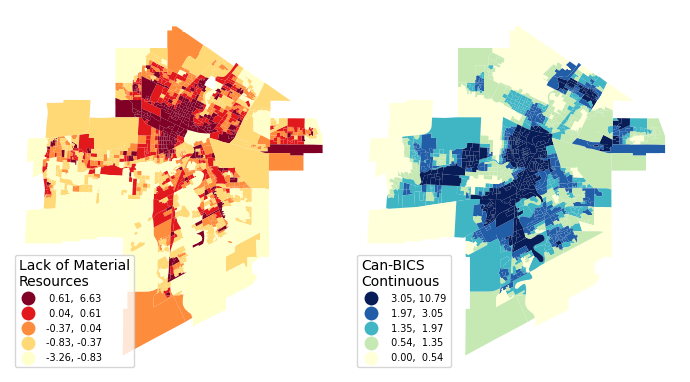

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(7,6))

gdf.plot(
    column = "material_resources_DA16", 
    cmap = 'YlOrRd', 
    scheme = "Quantiles", 
    legend = True,
    ax=ax[0],
    legend_kwds = {
        "loc": "lower left",
        "fontsize": 7,
        "title": "Lack of Material\nResources",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

gdf.plot(
    column = "CBICS_cont", 
    cmap = 'YlGnBu', 
    scheme = "Quantiles", 
    legend = True,
    ax=ax[1],
    legend_kwds = {
        "loc": "lower left",
        "fontsize": 7,
        "title": "Can-BICS\nContinuous",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

plt.tight_layout()

## Bivariate Classifications

The first step into creating a bivariate map is to classify our data.

I'll be focusing 3x3 classifications using quantiles.

Behind the scenes of the univariate choropleth maps above is the Python library [mapclassify](https://github.com/pysal/mapclassify). This library helps create.

For example, here's classifying the Can-BICS variable into `k = 3` quantiles:

In [6]:
mapclassify.Quantiles(gdf["CBICS_cont"], k = 3)

Quantiles

   Interval      Count
----------------------
[ 0.00,  1.15] |   373
( 1.15,  2.25] |   372
( 2.25, 10.79] |   373

We can use the same function to generate a bivariate classification. Below we create 3x3 square classification using quantiles. A `k = 3` for each variable `x` (Can-BICS cycling infrastructure quality) and `y` (Can-MARG lack of material resources), and then stitch the two together.

In [7]:
gdf['x_group'] = gdf[['CBICS_cont']].apply(mapclassify.Quantiles.make(rolling=True, k = 3))
gdf['y_group'] = gdf[['material_resources_DA16']].apply(mapclassify.Quantiles.make(rolling=True, k = 3))
gdf['xy_group'] = gdf['x_group'].astype(str) + "-" + gdf['y_group'].astype(str)

Here's a random sample of the result that we can use to spot check a few results

In [8]:
gdf[["dauid","material_resources_DA16","CBICS_cont","xy_group"]].sample(5)

dauid  material_resources_DA16  CBICS_cont xy_group
436  46110459                -0.717151    3.225831      2-0
628  46110683                 0.616759    1.225917      1-2
950  46111042                 0.091095    5.143450      2-1
773  46110842                 0.639424    1.222279      1-2
992  46111090                -1.035089    0.000000      0-0

Now we are ready to make a bivariate map!

We can also run something like `gdf.to_file("data/winnipeg-bivariate.geojson", driver='GeoJSON')` if we wanted to save the classified data to then view it in QGIS or use for web-mapping.

## Bivariate Colours

Now that we've classified our data, we can assign colours and make a map! Here are a few examples that we can choose from:

<img src="images/eg-legends.svg" width="600">

Let's try to make a simple map using `gpd.plot()` based on our classified data, and the first of these colour schemes. 

The data we have are categorical. To plot categorical data with custom colours, we first have to provide a dictionary to *map* each colour to each category

In [9]:
color_mapping = {
    "0-0": "#f7fcf5", 
    "0-1": "#f78fb6", 
    "0-2": "#f73593", 
    "1-0": "#a5e8cd", 
    "1-1": "#a58fb6", 
    "1-2": "#a53593", 
    "2-0": "#40dba7", 
    "2-1": "#408fa7",
    "2-2": "#403593"
}

We can then feed this into our plot. We're also going to add the two reference layers to make the map a bit more intuitive (the Winnipeg boundary and the streets layer)

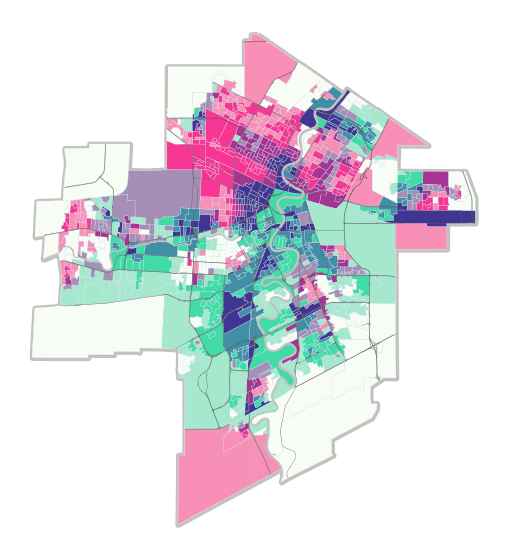

In [10]:
fig, ax = plt.subplots(figsize=(7,7))

# Winnipeg border
csd.plot(
    edgecolor = "#c2c2c2",
    linewidth = 4.2,
    ax = ax
);

# bivariate data
gdf.plot(
    column = "xy_group",
    categorical = True,
    edgecolor = "white",
    linewidth = 0.2,
    legend = True,
    ax = ax,
    color=gdf["xy_group"].map(color_mapping),
).set_axis_off();

# Winnipeg streets
osm_rivers.plot(
    color = "#c2c2c2",
    linewidth = 0,
    ax = ax
);

# Winnipeg streets
osm_streets.plot(
    color = "#5e5e5e",
    linewidth = 0.25,
    ax = ax
);

Looks great! but there isn't a legend, even though we specified `legend = True`. It looks like there's a [known issue](https://github.com/geopandas/geopandas/issues/1269) with plotting categorical data with custom colours. But that's okay. We'll finish up the map design and layout in Inkscape. Generally, I find I can do much more nuanced design of layout items, like legends, in graphic design software like Inkscape, especially if the goal is to create 'static' maps for a report, article, blog post, etc.  

In [11]:
fig.savefig('images/winnipeg-bivariate-map-python-export.svg')

## Layout Design in Inkscape

The above line of code exports the figure as an `.svg` (Scalable Vector Graphic).We can open this up in Inkscape and start adding layout items (title, legend, scale bar, north arrow, and other info). The page size is 7inches by 7inches (based on the `plt.subplots(figsize=(7,7))` at the top of the code used to render the map.

Generally, my work flow is to create at least three layers in the following order:
- layout (title, legend, scale bar, north arrow, and other info)
- map (in this case, the original exported .svg)
- background (often just a single rectangle with a solid fill colour)

Depending on how much design tweaking you want to do, the above, particularly the map and layout layers could be expanded into more layers (or sub-layers).

From a cartographic design side, I generally strive (to the best of my ability plus time constraints). For example, in the map below, I tried to balance the layout by putting one item in each corner. Purposely used the bottom-left corner for the legend, since it takes up the most space and fits nicely within the square-ish cutout of Winnipeg's border. I also used a grid to align some of the items such as the map frame, title, north arrow, and scale bar. These layout items didn't take too long to create, maybe around 20min or so.

Here's a screenshot of Inkscape showing all the items in the `layout` layer that I created.

<img src="images/inkscape-screenshot.png" width="700">

And here's the final map! We can export this to any resolution that we want. This is 300dpi for 7"x7" (2100x2100 px), a nice size for fitting into a report.

<img src="images/winnipeg-bivariate-map.png" width="699">

## Final Thoughts

The classification method (e.g. quantiles, equal breaks, etc.) can easily be edited as well as the number of classes and of course the colours. I shared a 3 examples of coloured legends above, but of course there are many more.

A drawback with bivariate maps is that they are often not intially intuitive and require more looking back-and-forth with the legend, especially compared to univariate choropleth maps. Even with a 3x3 legend like the map above, it can take a few seconds to read the map and understand and parse out specific values (especially for the middle values). If you're more interested in understanding each variable on it's own, rather than a direct comparison, it's probably best to stick with two side-by-side univariate choropleth maps.

If you want to allow for comparsion, but to keep things easier to read, a 2x2 legend might be better - or use a 3x3, but make the inner-cross all the same colour (i.e. just to highlight the High-High, Low-Low, Low-High, and High-Low values).


## Additional Resources

- [Wikipedia page on multivariate maps](https://en.wikipedia.org/wiki/Multivariate_map)
- [Color Statistical Mapping by the U.S. Bureau of the Census](https://doi.org/10.1559/152304075784313250) | (what I think might be the first published bivariate maps)
- [Bivariate maps in QGIS](https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/) | by Joshua Stevens
- [Bivariate maps in R](https://timogrossenbacher.ch/2019/04/bivariate-maps-with-ggplot2-and-sf/) | by Timo Grossenbacher
